In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

# 数据预处理

In [2]:
data = pd.read_csv("data/data.csv")

In [3]:
data.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [4]:
X      = data.iloc[:,:-1]
Y      = data.iloc[:,-1]

In [5]:
X_min = X.min()
X_max = X.max()
X     = (X - X_min) / (X_max - X_min)

In [6]:
X.head()

,Age,EstimatedSalary
0,0.023810,0.029630
1,0.404762,0.037037
2,0.190476,0.207407
3,0.214286,0.311111
4,0.023810,0.451852


# 创建模型

In [7]:
class Perceptron:
    def __init__(self, input_dim, lr=0.3):
        np.random.seed(0)                             # 以便复现结果
        self.weights = np.random.randn(input_dim, 1)  # 初始化权重矩阵
        self.bias    = np.random.randn(1)             # 初始化偏置
        self.lr      = lr                             # 初始化学习率
    
    # 激活函数
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # 前向传播
    def forward(self, x):
        x = np.dot(x, self.weights) + self.bias
        x = self.sigmoid(x)
        return x

    # 计算损失
    def loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    # 反向传播，更新参数
    def backprop(self, x, y):
        # 计算梯度
        y_pred    = self.forward(x)
        error     = y_pred - y
        d_weights = np.dot(x.T, 2 * error * y_pred * (1 - y_pred)) / len(y)
        d_bias    = np.sum(2 * error * y_pred * (1 - y_pred)) / len(y)
        
        # 更新参数
        self.weights -= self.lr * d_weights
        self.bias    -= self.lr * d_bias

In [8]:
class MLP:
    def __init__(self, input_dim, lr=0.1):
        np.random.seed(0)
       
        # [2,32] -> [32,64] -> [64,128] -> [128,1] 
        self.weights1 = np.random.randn(input_dim, 32) * np.sqrt(2. / input_dim)
        self.bias1    = np.zeros((1, 32))
        
        self.weights2 = np.random.randn(32, 64) * np.sqrt(2. / 32)
        self.bias2    = np.zeros((1, 64))
        
        self.weights3 = np.random.randn(64, 128) * np.sqrt(2. / 64)
        self.bias3    = np.zeros((1, 128))
        
        self.weights4 = np.random.randn(128, 1) * np.sqrt(2. / 128)
        self.bias4    = np.zeros((1, 1))
        
        self.lr = lr

    # ReLu激活函数
    def relu(self, z):
        return np.maximum(0, z)

    # Sigmoid激活函数
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # 前向传播过程
    def forward(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = self.relu(self.z1)
        
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.relu(self.z2)
        
        self.z3 = np.dot(self.a2, self.weights3) + self.bias3
        self.a3 = self.relu(self.z3)
        
        self.z4 = np.dot(self.a3, self.weights4) + self.bias4
        self.a4 = self.sigmoid(self.z4)
        
        return self.a4
    
    # 计算损失
    def loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    # 反向传播，更新参数
    def backprop(self, x, y):
        # 计算梯度
        d_a4       = 2 * (self.a4 - y)
        d_z4       = d_a4 * (self.a4 * (1 - self.a4))
        
        d_weights4 = np.dot(self.a3.T, d_z4)
        d_bias4    = np.sum(d_z4, axis=0, keepdims=True)
        
        d_a3       = np.dot(d_z4, self.weights4.T)
        d_z3       = d_a3 * (self.z3 > 0)
        d_weights3 = np.dot(self.a2.T, d_z3)
        d_bias3    = np.sum(d_z3, axis=0, keepdims=True)
        
        d_a2       = np.dot(d_z3, self.weights3.T)
        d_z2       = d_a2 * (self.z2 > 0)
        d_weights2 = np.dot(self.a1.T, d_z2)
        d_bias2    = np.sum(d_z2, axis=0, keepdims=True)
        
        d_a1       = np.dot(d_z2, self.weights2.T)
        d_z1       = d_a1 * (self.z1 > 0)
        d_weights1 = np.dot(x.T, d_z1)
        d_bias1    = np.sum(d_z1, axis=0, keepdims=True)
        
        # 更新参数
        self.weights1 -= self.lr * d_weights1
        self.bias1    -= self.lr * d_bias1
        self.weights2 -= self.lr * d_weights2
        self.bias2    -= self.lr * d_bias2
        self.weights3 -= self.lr * d_weights3
        self.bias3    -= self.lr * d_bias3
        self.weights4 -= self.lr * d_weights4
        self.bias4    -= self.lr * d_bias4

# 模型训练

In [9]:
input_dim  = X.shape[1]
model      = MLP(input_dim)

In [10]:
epochs     = 1000
batch_size = 32
losses     = []

In [11]:
for epoch in range(epochs):
    for i in range(0, X.shape[0], batch_size):
        x_batch = X.iloc[i:i + batch_size].values               # [batchsize, 2]
        y_batch = Y.iloc[i:i + batch_size].values.reshape(-1,1) # [batchsize, 1]
        
        # 前向传播
        y_pred       = model.forward(x_batch)                   # [batchsize, 1]
        
        # 计算损失
        current_loss = model.loss(y_pred, y_batch)
        
        # 反向传播，更新参数
        model.backprop(x_batch,y_batch)
    
    losses.append(current_loss)
    print(f'Epoch: {epoch + 1}, Loss: {current_loss}')

Epoch: 1, Loss: 0.2960908341598365
Epoch: 2, Loss: 0.20050190564111312
Epoch: 3, Loss: 0.09979747426270535
Epoch: 4, Loss: 0.05008778643089141
Epoch: 5, Loss: 0.03574465705342849
Epoch: 6, Loss: 0.024070736654382033
Epoch: 7, Loss: 0.003525342875517757
Epoch: 8, Loss: 0.008971898713974427
Epoch: 9, Loss: 0.02002531706950791
Epoch: 10, Loss: 0.028619617146413676
Epoch: 11, Loss: 0.021820421712615203
Epoch: 12, Loss: 0.02079406407370846
Epoch: 13, Loss: 0.02404965810343997
Epoch: 14, Loss: 0.01472656121161878
Epoch: 15, Loss: 0.014474441400605725
Epoch: 16, Loss: 0.01154852336066773
Epoch: 17, Loss: 0.009608535302031448
Epoch: 18, Loss: 0.01411260819209376
Epoch: 19, Loss: 0.01305675727800838
Epoch: 20, Loss: 0.010908981019545077
Epoch: 21, Loss: 0.011914846322304318
Epoch: 22, Loss: 0.012848994395673172
Epoch: 23, Loss: 0.013386181043975678
Epoch: 24, Loss: 0.01148912272078441
Epoch: 25, Loss: 0.009788683250391032
Epoch: 26, Loss: 0.010992703145944284
Epoch: 27, Loss: 0.0097858003402508

In [12]:
model.forward(X)

array([[8.24521671e-14],
       [7.90715904e-07],
       [2.76442621e-09],
       [3.88870455e-08],
       [1.95934359e-10],
       [4.20108792e-08],
       [6.73244976e-09],
       [1.00000000e+00],
       [2.15377448e-10],
       [4.01624390e-02],
       [3.40804656e-09],
       [5.65150892e-09],
       [5.36096391e-09],
       [1.82838020e-07],
       [1.25450920e-09],
       [7.42467052e-08],
       [9.99925958e-01],
       [9.99291946e-01],
       [9.99000115e-01],
       [9.99644787e-01],
       [9.99919644e-01],
       [8.20705347e-01],
       [6.35937345e-01],
       [9.99919644e-01],
       [9.99946456e-01],
       [9.99996160e-01],
       [9.99939697e-01],
       [9.98580450e-01],
       [4.37927100e-07],
       [1.50274542e-07],
       [9.57734274e-06],
       [9.99976644e-01],
       [7.84174473e-13],
       [8.38436179e-08],
       [2.43564197e-07],
       [4.64615583e-07],
       [1.28522615e-07],
       [3.11891356e-06],
       [3.78763172e-09],
       [1.74576798e-09],


In [13]:
results = (model.forward(X) > 0.5).astype(np.int32)

In [14]:
results

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [15]:
(results==np.array(Y).reshape(-1,1)).astype(np.int32).mean()

0.93

# 可视化

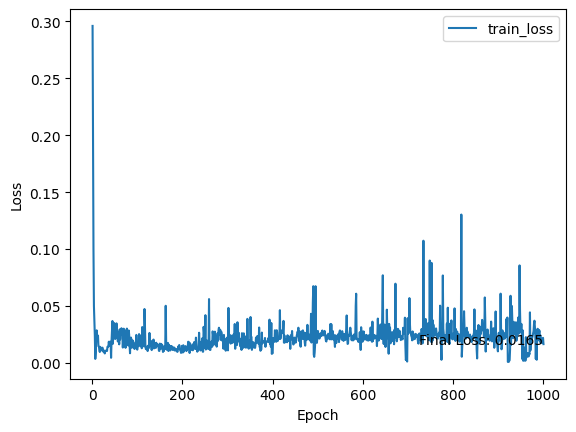

In [16]:
plt.plot(range(1,epochs+1),losses,label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.text(epochs, losses[-1], f'Final Loss: {losses[-1]:.4f}', ha='right', va='baseline')
plt.legend()

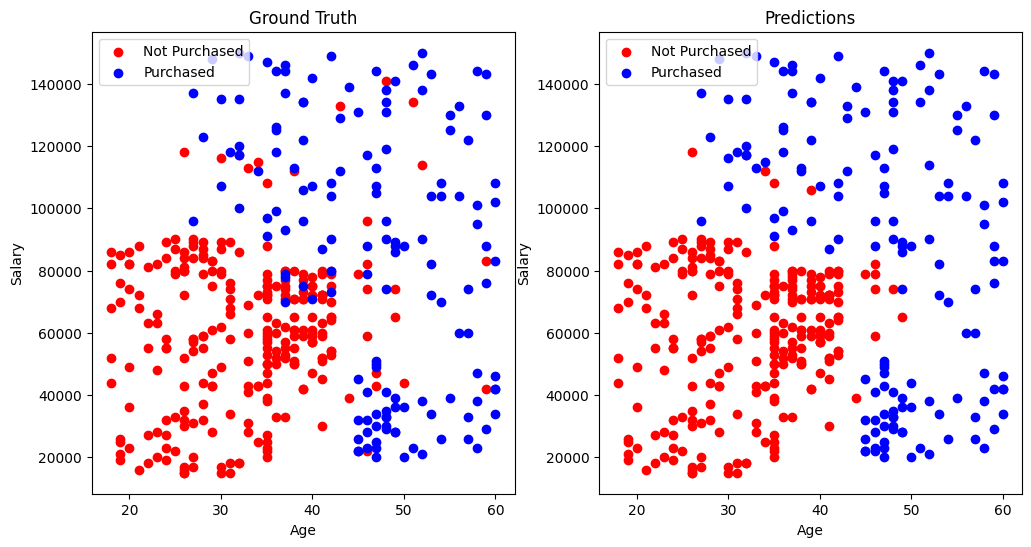

In [17]:
results         = results.flatten()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

X        = data.iloc[:,:-1]
Y        = data.iloc[:,-1]

feature1 = X.iloc[:, 0]
feature2 = X.iloc[:, 1]

ax1.scatter(feature1[Y == 0], feature2[Y == 0], color='red', label='Not Purchased')
ax1.scatter(feature1[Y == 1], feature2[Y == 1], color='blue', label='Purchased')
ax1.set_title('Ground Truth')
ax1.set_xlabel('Age')
ax1.set_ylabel('Salary')
ax1.legend()

ax2.scatter(feature1[results == 0], feature2[results == 0], color='red', label='Not Purchased')
ax2.scatter(feature1[results == 1], feature2[results == 1], color='blue', label='Purchased')
ax2.set_title('Predictions')
ax2.set_xlabel('Age')
ax2.set_ylabel('Salary')
ax2.legend()

plt.show()